In [1]:
#IMPORTS
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import torch
from urllib import request
import random
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda


In [ ]:
# # prepare logger
# logging.basicConfig(level=logging.INFO)

# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# # check gpu
# cuda_available = torch.cuda.is_available()

# print('Cuda available? ',cuda_available)
# if cuda_available:
#   import tensorflow as tf
#   # Get the GPU device name.
#   device_name = tf.test.gpu_device_name()
#   # The device name should look like the following:
#   if device_name == '/device:GPU:0':
#       print('Found GPU at: {}'.format(device_name))
#   else:
#       raise SystemError('GPU device not found')

In [2]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [3]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [4]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
print(len(trids), len(teids))
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

data=dpm.train_task1_df
data

8375 2094


,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [5]:

rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  orig_label = data.loc[data.par_id == parid].orig_label.values[0]
  item = {
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'orig_label': orig_label
  }
  rows.append(item)

In [6]:
trdf1 = pd.DataFrame(rows)
trdf1

,par_id,community,text,label,orig_label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1,4
1,4136,homeless,Durban 's homeless communities reconciliation ...,1,2
2,10352,poor-families,The next immediate problem that cropped up was...,1,4
3,8279,vulnerable,Far more important than the implications for t...,1,2
4,1164,poor-families,To strengthen child-sensitive social protectio...,1,4
...,...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0,0
8373,8383,hopeless,You have to see it from my perspective . I may...,0,0


In [7]:
test_rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  orig_label = data.loc[data.par_id == parid].orig_label.values[0]
  test_rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'orig_label': orig_label
  })
  #TODO: keyword?Country?length?

In [8]:
tedf1 = pd.DataFrame(test_rows)
tedf1

,par_id,community,text,label,orig_label
0,4046,hopeless,We also know that they can benefit by receivin...,1,3
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,4
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,2
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,3
...,...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0,0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0,0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0,0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0,1


In [9]:
tedf1 = tedf1.sample(frac = 1) # shuffle data
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
# training_set1 = pd.concat([training_set1, tedf1['community']], axis=1)
# tedf1.par_id
train_data = training_set1
test_data = tedf1
train_data_text_list = train_data.text.to_list()
train_data_label_list = train_data.label.to_list()
test_data_text_list = test_data.text.to_list()
test_data_label_list = test_data.label.to_list()
train_community = train_data.community.to_list()
test_community = test_data.community.to_list()
train_pcl = train_data.orig_label.to_list()
test_pcl = test_data.orig_label.to_list()
print(len(train_data_text_list))

2382


In [10]:
from sklearn.metrics import f1_score, accuracy_score
def calc_scores_and_print_miscalculations(true_lables, pred_labels, unseen_data, n=10):
    '''prints accuracy, f1 score and first N miscalculations'''
    calc_scores(true_lables, pred_labels)
    # Print predicted labels for unseen test data
    print("\nMisclassifications:")
    c = 0
    for text, true_label, pred_label in zip(unseen_data, true_lables, pred_labels):
        if true_label != pred_label:
            print(f"Pred: {pred_label} Ac: {true_label} Text: {text}")
            c += 1
            if c == n:
                break

def calc_scores(true_lables, pred_labels):
    # Evaluate the model
    accuracy = accuracy_score(true_lables, pred_labels)
    print("Accuracy:", accuracy)

    f1_result = f1_score(true_lables, pred_labels)
    print("F1 Score:", f1_result)
    return (accuracy, f1_result)

In [11]:
!pip install nltk

## Pre-processing/Augmentatoin and sampling helper methods

In [12]:
!pip install -q googletrans
!pip install -q deep_translator

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.4 MB/s eta 0:00:00


In [13]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
# Download WordNet if not already downloaded
nltk.download('wordnet')
nltk.download('stopwords')

# Synonm augmentation
stop_words = set(stopwords.words('english'))

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(text, n=3):
    words = text.split()
    augmented_texts = []
    for _ in range(n):
        new_words = words.copy()
        for i, word in enumerate(words):
            if word.lower() not in stop_words:  # Check if the word is not a stop word
                synonyms = get_synonyms(word)
                if synonyms:
                    synonym = random.choice(synonyms)
                    new_words[i] = synonym
        augmented_texts.append(' '.join(new_words))
    return augmented_texts

# Example usage:
original_text = "Somebody destroyed my only toy"
augmented_texts = synonym_replacement(original_text, n=3)  # Generate 3 augmented texts
for i, augmented_text in enumerate(augmented_texts, 1):
    print(f"Augmented Text {i}: {augmented_text}")


def replacement_text(text_list, label_list, transform_f=synonym_replacement):
    aug_text_list = []
    aug_label_list = []
    for text, label in zip(text_list, label_list):
        options = transform_f(text)
        aug_text_list.append(text)
        aug_text_list.extend(options)
        aug_label_list.append(label)
        aug_label_list.extend([label] * len(options))
    return aug_text_list, aug_label_list

from sklearn.cluster import KMeans
from scipy.sparse import vstack
from sklearn.cluster import KMeans
import numpy as np


# Not working fully
def cluster_sampling(X_train_bow, y_train):
    ''' Uses KMEANS and requires that X_train is alreayd in feature form e.g. Bag Of words or TF-IDF, vectorized form'''
    # Step 1: Cluster-based Sampling
    num_clusters = 5  # Number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_train_bow)

    # Sample size per cluster
    sample_size_per_cluster = 100

    X_train_sampled = []
    y_train_sampled = []

    for cluster_id in range(num_clusters):
        cluster_indices = (clusters == cluster_id).nonzero()[0]
        sampled_indices = np.random.choice(cluster_indices, size=min(sample_size_per_cluster, len(cluster_indices)), replace=False)
        X_train_sampled.extend(X_train_bow[sampled_indices])
        y_train_sampled.extend([y_train[i] for i in sampled_indices])
    return X_train_sampled, y_train_sampled

import random
import numpy as np
from googletrans import Translator
import os
import json
from deep_translator import GoogleTranslator

def translate_group(text_list, label_list):
    aug_text_list = []
    aug_label_list = []
    choices = ['fr', 'de', 'ar']
    translators_to = [GoogleTranslator(source='en', target=x) for x in choices]
    translators_from = [GoogleTranslator(source=x, target='en') for x in choices]
    for text, label in zip(text_list, label_list):
        aug_text_list.append(text)
        for i in range(3):
            new_text = [translators_from[i].translate(translators_to[i].translate(text))]
            aug_text_list.extend(new_text)
        aug_label_list.append(label)
        aug_label_list.extend([label] * len(new_text))
    return aug_text_list, aug_label_list

import pickle
def write_list_to_file(list1, filename1):
    with open(filename1, 'wb') as file:
        pickle.dump(list1, file)
def read_list_from_file(filename1):
    with open(filename1, 'rb') as file:
        return pickle.load(file)

# res1, res2 = translate_group(train_data_text_list[:1] , train_data_label_list[:1])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Augmented Text 1: someone ruined my only plaything
Augmented Text 2: somebody destroy my only flirt
Augmented Text 3: person destruct my only flirt


In [ ]:
# Computationally expensive transformations
X_aug, y_aug = replacement_text(train_data_text_list, train_data_label_list, synonym_replacement)

In [ ]:
# X,y = train_data_text_list, train_data_label_list
X, y = train_data_text_list, train_data_label_list
# X,y = read_list_from_file("french_translation_text.txt"), read_list_from_file("french_translation_label.txt")

## Benchmark - Bag of words (no augmentation)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
from scipy.sparse import vstack
# Example dataset (X: text data, y: sentiment labels)
print(len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define stopwords and create CountVectorizer with n-grams and stopwords removal
stop_words = list(stop_words)
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)

# Create BoW vectors
maxv = -float('inf')
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Step 2: Train a logistic regression classifier on the sampled data
classifier = LogisticRegression()
classifier.fit(X_train_bow, y_train)

# Step 3: Evaluate the model
y_pred = classifier.predict(X_test_bow)
calc_scores(y_test, y_pred)

# Unseen data
unseen_data = test_data_text_list
true_labels = test_data_label_list

# Vectorize the unseen test data using the same CountVectorizer instance
X_unseen_bow = vectorizer.transform(unseen_data)

# Predict sentiment labels for the unseen test data
y_unseen_pred = classifier.predict(X_unseen_bow)

# Calculate f1_score
acc, f1 = calc_scores(true_labels, y_unseen_pred)

# calc_scores_and_print_miscalculations(true_labels, y_unseen_pred, unseen_data)

2382
Accuracy: 0.7526205450733753
F1 Score: 0.562962962962963
Accuracy: 0.8424068767908309
F1 Score: 0.3153526970954357


## Benchmark model - SVM - TF-IDF feature representation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:

# Split the dataset into training and testing sets
# X,y = train_data_text_list[:300] + train_data_text_list[-300:], train_data_label_list[:300] +  train_data_label_list[-300:]
X, y = train_data_text_list, train_data_label_list
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

# Predict sentiment labels for the test set
y_pred = svm_classifier.predict(X_test_tfidf)

calc_scores(y_test, y_pred)

# Example of unseen test data
unseen_data = test_data_text_list
true_labels = test_data_label_list # True sentiment labels for the unseen test data

# Convert the unseen test data into TF-IDF vectors
X_unseen_tfidf = tfidf_vectorizer.transform(unseen_data)

# Predict sentiment labels for the unseen test data
y_unseen_pred = svm_classifier.predict(X_unseen_tfidf)

# Calculate accuracy for unseen test data
calc_scores_and_print_miscalculations(true_labels, y_unseen_pred, unseen_data)


Accuracy: 0.7610062893081762
F1 Score: 0.6174496644295302
Accuracy: 0.8414517669531996
F1 Score: 0.336

Misclassifications:
Pred: 1 Ac: 0 Text: "The minister said the Supreme Court had given a "" hopeless verdict "" , making people take to the street to show their resentment . He said that court proceedings on the JIT reports should be conducted in an open court . He said , "" We faced injustices during military ruler Zia-ul-Haq 's rule and sustained bullet injuries . We have made a commitment to the souls of Zulfikar Ali Bhutto and Benazir Bhutto that we will rid the country of Nawaz Sharif and his corrupt family . """
Pred: 0 Ac: 1 Text: NEW DELHI : Activists and medical professionals have lauded the government 's move to increase the ambit of the disabled list to offer benefits to acid attack survivors , those suffering from chronic neurological conditions , and haemophilia and sickle cell anaemia patients . This , they said , will help in integrating them into society .
Pred: 0 Ac:

## Analysis - visualisation (matplotlib)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Combine the sequences, true labels, and predicted labels into a list of tuples
data = list(zip(unseen_data, true_labels, y_unseen_pred))

# Sort the data based on the length of the input sequences
sorted_data = sorted(data, key=lambda x: len(x[0].split()))

# Define the number of groups
n_groups = 5

# Calculate the group size
group_size = len(sorted_data) // (n_groups + 1)

# Divide the sorted data into n_groups approximately equal-sized groups
groups = [sorted_data[i:i+group_size] for i in range(0, len(sorted_data), group_size)]
print(len(groups))
# Initialize counters for correctly predicted labels
group_correct = [0] * (n_groups + 1)

# Iterate through each group and count the number of correctly predicted labels
for i, group in enumerate(groups):
    for seq, true_label, pred_label in group:
        if true_label == pred_label:
            group_correct[min(i, len(group_correct) - 1)] += 1  # Ensure index doesn't exceed the length of group_correct

# Calculate accuracy percentage for each group
group_sizes = [len(group) for group in groups]
group_accuracies = [(correct / size) * 100 if size != 0 else 0 for correct, size in zip(group_correct, group_sizes)]

# Plot the results
# Calculate the amount of characters at the end of each group
end_char_counts = [len(group[-1][0]) for group in groups]
categories = [f'{end_char_count} chars' for end_char_count in end_char_counts]
print(categories)
accuracies = group_accuracies

plt.bar(categories, accuracies, color=['skyblue'])
plt.xlabel('Input Sequence Length Group')
plt.ylabel('Accuracy Percentage')
plt.title('Accuracy Percentage by Input Sequence Length Group')
plt.ylim(0, 100)
plt.show()


0 1704
3 89
1 191
2 18
4 92
disabled 194
hopeless 217
immigrant 218
homeless 212
vulnerable 209
migrant 207
refugee 188
women 233
poor-families 190
in-need 226


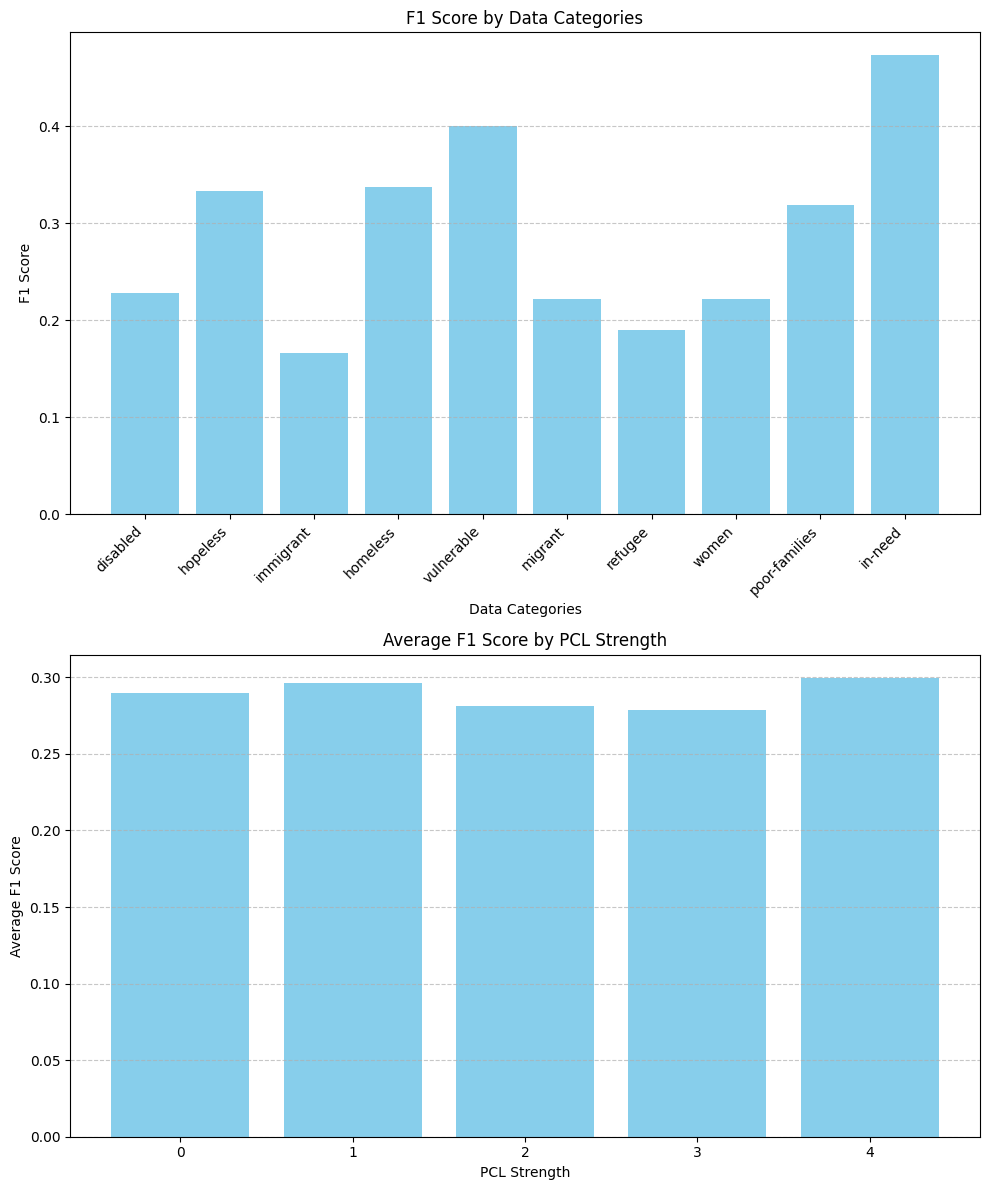

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score

# Group data based on categories
data_categories = test_community  # True labels
pcl_strength = test_pcl
c2 = Counter(pcl_strength)
for k,v in c2.items():
    print(k,v)
c = Counter(data_categories)
for k,v in c.items():
    print(k, v)

category_data = {}
for category, true_label, pred_label, pcl_strength_val in zip(data_categories, true_labels, y_unseen_pred, pcl_strength):
    if category not in category_data:
        category_data[category] = {'true_labels': [], 'pred_labels': [], 'pcl_strength': []}
    category_data[category]['true_labels'].append(true_label)
    category_data[category]['pred_labels'].append(pred_label)
    category_data[category]['pcl_strength'].append(pcl_strength_val)

# Calculate F1 score for each category
category_f1_scores = {}
for category, data in category_data.items():
    category_f1_scores[category] = f1_score(data['true_labels'], data['pred_labels'])
    # category_f1_scores[category] = accuracy_score(data['true_labels'], data['pred_labels'])

# Plot the results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot for data_categories
axes[0].bar(range(len(category_f1_scores)), category_f1_scores.values(), color='skyblue')
axes[0].set_xlabel('Data Categories')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score by Data Categories')
axes[0].set_xticks(range(len(category_f1_scores)))
axes[0].set_xticklabels(list(category_f1_scores.keys()), rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for pcl_strength
pcl_strength_data = {}
for category, data in category_data.items():
    for pcl_strength_val, f1_score_val in zip(data['pcl_strength'], category_f1_scores.values()):
        if pcl_strength_val not in pcl_strength_data:
            pcl_strength_data[pcl_strength_val] = []
        pcl_strength_data[pcl_strength_val].append(f1_score_val)

# Sort pcl_strength_data by keys (PCL strength)
sorted_pcl_strength_data = dict(sorted(pcl_strength_data.items()))

axes[1].bar(range(len(sorted_pcl_strength_data)), [sum(scores)/len(scores) for scores in sorted_pcl_strength_data.values()], color='skyblue')
axes[1].set_xlabel('PCL Strength')
axes[1].set_ylabel('Average F1 Score')
axes[1].set_title('Average F1 Score by PCL Strength')
axes[1].set_xticks(range(len(sorted_pcl_strength_data)))
axes[1].set_xticklabels(sorted_pcl_strength_data.keys())
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## DeBERTa model augmentations


In [16]:
!pip install -q simpletransformers
!pip install -q tensorboardx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 1

In [17]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split

In [61]:
# Prepare dataset for training and validation
x = train_data_text_list
y = train_data_label_list
print(f"Train size: {len(x)}, labels size: {len(y)}")

# data should be passed in as x, y in case want augmentations.
def train_and_output_deberta(model_args, optimisation_name=""):
    # Define model
    x_train, x_val, y_train, y_val = train_test_split(train_data_text_list, train_data_label_list, test_size=0.2, random_state=42)

    # Combining dataset for training
    train_df = pd.DataFrame({'text':x_train, 'label':y_train})

    # Defining testing variables
    x_test = test_data_text_list
    y_test_label = test_data_label_list
    deberta_model = ClassificationModel("deberta",
                                      'microsoft/deberta-base',
                                      args = model_args,
                                      num_labels=2,
                                      use_cuda=torch.cuda.is_available())

    # Training the model
    deberta_model.train_model(train_df)

    # Evaluate the model on the validation set
    y_pred, _ = deberta_model.predict(x_val)
    print("DeBERTa " + optimisation_name + ". Validation set")
    calc_scores(y_val, y_pred)

    # Evaluate the model on the test set
    y_test_pred, _ = deberta_model.predict(x_test)
    print("DeBERTa " + optimisation_name + ". Test set")
    acc, f1 = calc_scores(y_test_label, y_test_pred)
    return f1

Train size: 2382, labels size: 2382


In [ ]:
deberta_names = []
deberta_f1_outputs = []

In [ ]:
# @title DeBERTa base model without augmentations
deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_base_model_args, "Base model")

# deberta_names.append("Base model")
# deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Base model. Validation set
Accuracy: 0.8029350104821803
F1 Score: 0.7445652173913044


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Base model. Test set
Accuracy: 0.8156638013371538
F1 Score: 0.46831955922865015


In [ ]:
# @title DeBERTa 3 epochs
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=3,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "3 epochs")

deberta_names.append("3 ep")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa 3 epochs. Validation set
Accuracy: 0.8029350104821803
F1 Score: 0.7151515151515152


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa 3 epochs. Test set
Accuracy: 0.8576886341929322
F1 Score: 0.49146757679180886


In [ ]:
# @title DeBERTa 5 epochs
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=5,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "5 epochs")

deberta_names.append("5 ep")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa 5 epochs. Validation set
Accuracy: 0.7882599580712788
F1 Score: 0.7122507122507122


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa 5 epochs. Test set
Accuracy: 0.8347659980897804
F1 Score: 0.47575757575757577


In [ ]:
# @title DeBERTa 10 epochs
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=5,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "10 epochs")

deberta_names.append("10 ep")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa 10 epochs. Validation set
Accuracy: 0.8071278825995807
F1 Score: 0.724550898203593


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa 10 epochs. Test set
Accuracy: 0.8615090735434575
F1 Score: 0.5017182130584192


In [ ]:
# Define model args
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=1,
                                      learning_rate=1e-5,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "Learning rate 1e-5")

deberta_names.append("1e-5 lr")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Learning rate 1e-5. Validation set
Accuracy: 0.750524109014675
F1 Score: 0.6148867313915857


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Learning rate 1e-5. Test set
Accuracy: 0.8514804202483286
F1 Score: 0.45342706502636204


In [ ]:
# Define model args
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=1,
                                      learning_rate=1e-4,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "Learning rate 1e-4") # Too big

deberta_names.append("1e-4 lr")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Learning rate 1e-4. Validation set
Accuracy: 0.6624737945492662
F1 Score: 0.0


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Learning rate 1e-4. Test set
Accuracy: 0.9049665711556829
F1 Score: 0.0


In [ ]:
# Define model args
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=5,
                                      learning_rate=1e-5,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "5 epochs, Learning rate 1e-5")

deberta_names.append("5 ep, 1e-5 lr")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa 5 epochs, Learning rate 1e-5. Validation set
Accuracy: 0.8238993710691824
F1 Score: 0.7485029940119761


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa 5 epochs, Learning rate 1e-5. Test set
Accuracy: 0.8696275071633238
F1 Score: 0.5365025466893039


In [ ]:
# Define model args
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=10,
                                      learning_rate=1e-5,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "10 epochs, Learning rate 1e-5")

deberta_names.append("10 ep, 1e-5 lr")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa 10 epochs, Learning rate 1e-5. Validation set
Accuracy: 0.8259958071278826
F1 Score: 0.7492447129909365


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa 10 epochs, Learning rate 1e-5. Test set
Accuracy: 0.8729703915950334
F1 Score: 0.5413793103448276


In [ ]:
# Define model args
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=5,
                                      learning_rate=1e-5,
                                      weight_decay=1e-6,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "5 epochs, Learning rate 1e-5, weight decay 1e-6")

deberta_names.append("5 ep, 1e-5 lr, 1e-6 wd")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa 5 epochs, Learning rate 1e-5, weight decay 1e-6. Validation set
Accuracy: 0.8197064989517819
F1 Score: 0.7470588235294118


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa 5 epochs, Learning rate 1e-5, weight decay 1e-6. Test set
Accuracy: 0.8638968481375359
F1 Score: 0.5289256198347106


In [ ]:
# Define model args
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=10,
                                      learning_rate=1e-5,
                                      weight_decay=1e-6,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "10 epochs, Learning rate 1e-5, weight decay 1e-6")

deberta_names.append("10 ep, 1e-5 lr, 1e-6 wd")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa 10 epochs, Learning rate 1e-5, weight decay 1e-6. Validation set
Accuracy: 0.8134171907756813
F1 Score: 0.726153846153846


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa 10 epochs, Learning rate 1e-5, weight decay 1e-6. Test set
Accuracy: 0.8844317096466093
F1 Score: 0.5583941605839416


In [ ]:
# Define model args
deberta_epochs_model_args = ClassificationArgs(num_train_epochs=10,
                                      learning_rate=1e-5,
                                      weight_decay=1e-5,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

f1 = train_and_output_deberta(deberta_epochs_model_args, "10 epochs, Learning rate 1e-5, weight decay 1e-5")

deberta_names.append("10 ep, 1e-5 lr, 1e-5 wd")
deberta_f1_outputs.append(f1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa 10 epochs, Learning rate 1e-5, weight decay 1e-5. Validation set
Accuracy: 0.8155136268343816
F1 Score: 0.7411764705882354


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa 10 epochs, Learning rate 1e-5, weight decay 1e-5. Test set
Accuracy: 0.8595988538681948
F1 Score: 0.5180327868852459


## DeBERTa model analysis for model augmentation


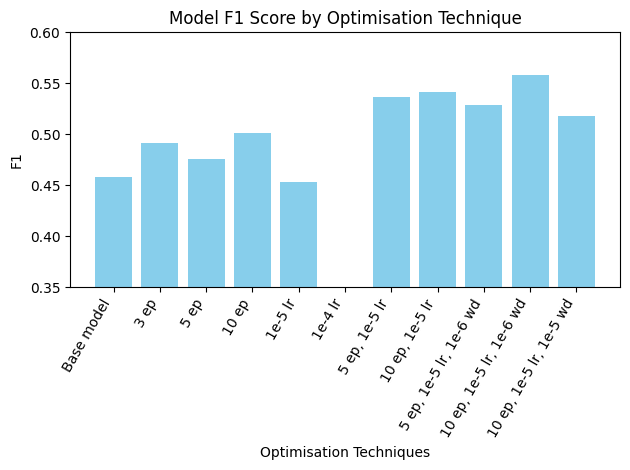

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Name of optimisations compared to base model
# optimisations = ["Base model", "3 ep", "5 ep", "10 ep", "1e-5 lr", "1e-4 lr", "5 ep,1e-5 lr", "10 ep,1e-5 lr", "5 ep,1e-5 lr, 1e-6 wd", "10 ep,1e-5 lr, 1e-6 wd", "10 ep,1e-5 lr, 1e-5 wd", "1e-5 lr,10 ep,early stop (0.01\ndelta),100 warmup steps"]
# Outputs are the F1 scores. Collected manually from cells' results to prevent retraining the models
# outputs = [0.479, 0.484, 0.480, 0.503, 0.480, 0.371, 0.554, 0.541, 0.537, 0.560, 0.523, 0.537]

# bars = plt.bar(optimisations, outputs, color=['skyblue'])
bars = plt.bar(deberta_names, deberta_f1_outputs, color=['skyblue'])
plt.xlabel('Optimisation Techniques')
plt.ylabel('F1')
plt.title('Model F1 Score by Optimisation Technique')
plt.xticks(rotation=60, ha='right')  # Rotate names to prevent overlap
plt.ylim(0.35, 0.6)  # Adjusted for better visibility

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


The best model is 10 ep, 1e-5 lr, 1e-5 wd. We will use it further with different data augmentation techniques to see how they affect the performance further.

In [18]:
# @title DeBERTA with early stopping
model_args = ClassificationArgs(num_train_epochs=10,
                                  learning_rate=1e-5,
                                  weight_decay=1e-6,
                                  do_lower_case=True,
                                  no_save=True,
                                  no_cache=True,
                                  overwrite_output_dir=True,
                                  use_multiprocessing=False,
                                  use_multiprocessing_for_evaluation=False,
                                  dataloader_num_workers=8,)

model_args.use_early_stopping = True  # Enable early stopping
model_args.early_stopping_patience = 3  # Number of evaluations to wait for improvement before stopping
model_args.early_stopping_delta = 0.01  # Minimum improvement needed to count as an improvement
model_args.early_stopping_metric = "eval_loss"  # Metric used for early stopping
model_args.early_stopping_metric_minimize = True  # Set to True if the metric should decrease (typical for loss)

train_text, train_labels = train_data_text_list, train_data_label_list
# Define datasets
x_train, x_val, y_train, y_val = train_test_split(train_text, train_labels, test_size=0.2, random_state=42)

# Combining dataset for training
train_df = pd.DataFrame({'text':x_train, 'label':y_train})
eval_df =  pd.DataFrame({'text':x_val, 'label':y_val})

# Initialize and train the model
deberta_model = ClassificationModel("deberta", "microsoft/deberta-base", args=model_args, use_cuda=torch.cuda.is_available())
deberta_model.train_model(train_df, eval_df=eval_df)  # Assuming you have a train_df and an eval_df

# Evaluate the model on the validation set
y_pred, _ = deberta_model.predict(x_val)
print("DeBERTa early stop. Validation set")
calc_scores(y_val, y_pred)

# Defining testing variables
x_test = test_data_text_list
y_test_label = test_data_label_list

# Evaluate the model on the test set
y_test_pred, _ = deberta_model.predict(x_test)
print("DeBERTa early stop.. Test set")
acc, f1 = calc_scores(y_test_label, y_test_pred)
# doing 5 epochs for some reason
# x = [words.lower() for words in x]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa early stop. Validation set
Accuracy: 0.8092243186582809
F1 Score: 0.7217125382262997


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c05b942fb50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa early stop.. Test set
Accuracy: 0.8758357211079274
F1 Score: 0.5563139931740614


## DeBERTa data augmentations

In [21]:
# @title imports
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [27]:
# @title Training with different datasets

base_model_args = ClassificationArgs(num_train_epochs=10,
                                  learning_rate=1e-5,
                                  weight_decay=1e-6,
                                  no_save=True,
                                  no_cache=True,
                                  overwrite_output_dir=True,
                                  use_multiprocessing=False,
                                  use_multiprocessing_for_evaluation=False,
                                  dataloader_num_workers=8,)

# data should be passed in as x, y in case want augmentations.
def train_and_output_deberta_data_augmentation(train_text, train_labels, model_args=base_model_args, optimisation_name=""):
    # Define datasets
    x_train, x_val, y_train, y_val = train_test_split(train_text, train_labels, test_size=0.2, random_state=42)

    # Combining dataset for training
    train_df = pd.DataFrame({'text':x_train, 'label':y_train})
    eval_df = pd.DataFrame({'text':x_val, 'label':y_val})

    # Define model
    deberta_model = ClassificationModel("deberta",
                                      'microsoft/deberta-base',
                                      args=model_args,
                                      num_labels=2,
                                      use_cuda=torch.cuda.is_available())

    # Training the model
    deberta_model.train_model(train_df, eval_df=eval_df)

    # Evaluate the model on the validation set
    y_pred, _ = deberta_model.predict(x_val)
    print("DeBERTa " + optimisation_name + ". Validation set")
    calc_scores(y_val, y_pred)

    # Defining testing variables
    x_test = test_data_text_list
    y_test_label = test_data_label_list

    # Evaluate the model on the test set
    y_test_pred, _ = deberta_model.predict(x_test)
    print("DeBERTa " + optimisation_name + ". Test set")
    acc, f1 = calc_scores(y_test_label, y_test_pred)
    return f1

In [59]:
# @title DeBERTA with upsampled minority class
from sklearn.utils import resample

minority_df = trdf1[trdf1.label==1]
majority_df = trdf1[trdf1.label==0]

print(len(minority_df))
print(len(majority_df))
# Calculate the desired number of samples. Here, matching the majority class size or setting a specific target size
desired_samples = len(majority_df) // 2

# Perform oversampling of the minority class
minority_oversampled = resample(minority_df,
                                replace=True,  # Sample with replacement
                                n_samples=desired_samples,  # Match majority class
                                random_state=123)  # Reproducible results

# Concatenate the majority class with the oversampled minority class
training_set1 = pd.concat([majority_df, minority_oversampled])

# Shuffle the training set to mix minority and majority class samples
training_set1 = training_set1.sample(frac=1, random_state=123).reset_index(drop=True)

x = training_set1.text.to_list()
y = training_set1.label.to_list()

train_and_output_deberta_data_augmentation(x, y, optimisation_name="Upsampling")


794
7581


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/1137 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c05b942fb50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


  0%|          | 0/23 [00:00<?, ?it/s]

DeBERTa Upsampling. Validation set
Accuracy: 0.9701098901098901
F1 Score: 0.9559014267185474


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Upsampling. Test set
Accuracy: 0.9269340974212035
F1 Score: 0.6066838046272495


0.6066838046272495

In [23]:
deberta_data_names = []
deberta_data_f1_outputs = []

In [33]:
# @title DeBERTA base with lower
model_args = ClassificationArgs(num_train_epochs=10,
                                  learning_rate=1e-5,
                                  weight_decay=1e-6,
                                  do_lower_case=True,
                                  no_save=True,
                                  no_cache=True,
                                  overwrite_output_dir=True,
                                  use_multiprocessing=False,
                                  use_multiprocessing_for_evaluation=False,
                                  dataloader_num_workers=8,)

# doing 5 epochs for some reason
x, y = train_data_text_list, train_data_label_list
# x = [words.lower() for words in x]
train_and_output_deberta_data_augmentation(x, y, model_args, "Uncase")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Uncase. Validation set
Accuracy: 0.8176100628930818
F1 Score: 0.7339449541284404


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Uncase. Test set
Accuracy: 0.8801337153772684
F1 Score: 0.5509838998211091


0.5509838998211091

In [35]:
# @title DeBERTA with translated extra text
x, y = read_list_from_file("3_lang_translate_text.pkl"), read_list_from_file("3_lang_labels.pkl")
train_and_output_deberta_data_augmentation(x, y, optimisation_name="Translation")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

DeBERTa Translation. Validation set
Accuracy: 0.9952780692549843
F1 Score: 0.9932381667918858


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Translation. Test set
Accuracy: 0.8787010506208214
F1 Score: 0.5415162454873645


0.5415162454873645

In [36]:
# @title DeBERTA with stopword removal
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

x, y = train_data_text_list, train_data_label_list

# Function to remove stop words from a sentence
def remove_stop_words(sentence):
    tokens = sentence.split()  # Split sentence into words
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(filtered_tokens)  # Rejoin words into a sentence

# Apply stop word removal to the dataset
x = [remove_stop_words(sentence) for sentence in x]  # Remove stop words
train_and_output_deberta_data_augmentation(x, y, optimisation_name="No stopword")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa No stopword. Validation set
Accuracy: 0.8176100628930818
F1 Score: 0.7402985074626867


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa No stopword. Test set
Accuracy: 0.9040114613180515
F1 Score: 0.508557457212714


0.508557457212714

In [40]:
# @title DeBERTA with do_lower + lower input
model_args = ClassificationArgs(num_train_epochs=10,
                                  learning_rate=1e-5,
                                  weight_decay=1e-6,
                                  do_lower_case=True,
                                  no_save=True,
                                  no_cache=True,
                                  overwrite_output_dir=True,
                                  use_multiprocessing=False,
                                  use_multiprocessing_for_evaluation=False,
                                  dataloader_num_workers=8,)

# doing 5 epochs for some reason
x, y = train_data_text_list, train_data_label_list
x = [words.lower() for words in x]
train_and_output_deberta_data_augmentation(x, y, model_args, optimisation_name="Uncase + lower input")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Uncase + lower input. Validation set
Accuracy: 0.8155136268343816
F1 Score: 0.7283950617283951


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Uncase + lower input. Test set
Accuracy: 0.8615090735434575
F1 Score: 0.5307443365695793


0.5307443365695793

In [54]:
# @title DeBERTA with translated extra text + increased weight decay
model_args = ClassificationArgs(num_train_epochs=10,
                                  learning_rate=1e-5,
                                  weight_decay=1e-5,
                                  do_lower_case=True,
                                  no_save=True,
                                  no_cache=True,
                                  overwrite_output_dir=True,
                                  use_multiprocessing=False,
                                  use_multiprocessing_for_evaluation=False,
                                  dataloader_num_workers=8,)

x, y = read_list_from_file("3_lang_translate_text.pkl"), read_list_from_file("3_lang_labels.pkl")
train_and_output_deberta_data_augmentation(x, y, optimisation_name="Translation, increased wd")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

DeBERTa Translation, increased wd. Validation set
Accuracy: 0.9963273871983211
F1 Score: 0.9947643979057591


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Translation, increased wd. Test set
Accuracy: 0.8691499522445081
F1 Score: 0.5176056338028169


0.5176056338028169

In [57]:
# @title DeBERTA with adding categorical column
community_column = train_data.community.to_list()
text_column = train_data_text_list
x = [community + " " + text for community, text in zip(community_column, text_column)]
y = train_data_label_list

train_and_output_deberta_data_augmentation(x, y, optimisation_name="Add community column")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Add community column. Validation set
Accuracy: 0.8071278825995807
F1 Score: 0.7261904761904763


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Add community column. Test set
Accuracy: 0.894937917860554
F1 Score: 0.5238095238095238


0.5238095238095238

In [ ]:
# @title DeBERTA with translated extra text with early stopping uncased
model_args = ClassificationArgs(num_train_epochs=10,
                                  learning_rate=1e-5,
                                  weight_decay=1e-6,
                                  do_lower_case=True,
                                  no_save=True,
                                  no_cache=True,
                                  overwrite_output_dir=True,
                                  use_multiprocessing=False,
                                  use_multiprocessing_for_evaluation=False,
                                  dataloader_num_workers=8,)

model_args.use_early_stopping = True
model_args.early_stopping_patience = 3
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = "eval_loss"
model_args.early_stopping_metric_minimize = True

x, y = read_list_from_file("3_lang_translate_text.pkl"), read_list_from_file("3_lang_labels.pkl")
train_and_output_deberta_data_augmentation(x, y, model_args, "Uncase, translation, early stop")

In [56]:
# @title DeBERTA with adding categorical column + lower
model_args = ClassificationArgs(num_train_epochs=10,
                                  learning_rate=1e-5,
                                  weight_decay=1e-6,
                                  do_lower_case=True,
                                  no_save=True,
                                  no_cache=True,
                                  overwrite_output_dir=True,
                                  use_multiprocessing=False,
                                  use_multiprocessing_for_evaluation=False,
                                  dataloader_num_workers=8,)

community_column = train_data.community.to_list()
text_column = train_data_text_list
x = [community + " " + text for community, text in zip(community_column, text_column)]
y = train_data_label_list
x = [words.lower() for words in x]

train_and_output_deberta_data_augmentation(x, y, model_args, optimisation_name="Add community column")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Add community column. Validation set
Accuracy: 0.7966457023060797
F1 Score: 0.7087087087087087


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Add community column. Test set
Accuracy: 0.8896848137535817
F1 Score: 0.5177453027139874


0.5177453027139874

## DeBERT base model with different data augmentation techniques

In [67]:
# @title DeBERTa base model with do_lower_case = true
deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      do_lower_case=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

x = train_data_text_list
y = train_data_label_list
x = [words.lower() for words in x]
train_and_output_deberta_data_augmentation(x, y, deberta_base_model_args, "Base model + do_lower_case")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Base model + do_lower_case. Validation set
Accuracy: 0.8238993710691824
F1 Score: 0.7218543046357615


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Base model + do_lower_case. Test set
Accuracy: 0.8691499522445081
F1 Score: 0.5159010600706714


0.5159010600706714

In [63]:
# @title DeBERTA base with adding categorical column
community_column = train_data.community.to_list()
text_column = train_data_text_list
x = [community + " " + text for community, text in zip(community_column, text_column)]
y = train_data_label_list

deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      do_lower_case=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

train_and_output_deberta_data_augmentation(x, y, deberta_base_model_args, optimisation_name="Add community column")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Add community column. Validation set
Accuracy: 0.8155136268343816
F1 Score: 0.7411764705882354


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Add community column. Test set
Accuracy: 0.8705826170009551
F1 Score: 0.5152057245080502


0.5152057245080502

In [69]:
# @title DeBERTA base with adding categorical column twice
community_column = train_data.community.to_list()
text_column = train_data_text_list
x = [community + " " + text + " " + community for community, text in zip(community_column, text_column)]
y = train_data_label_list

deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      do_lower_case=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

train_and_output_deberta_data_augmentation(x, y, deberta_base_model_args, optimisation_name="Add community column twice")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa Add community column twice. Validation set
Accuracy: 0.8155136268343816
F1 Score: 0.721518987341772


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Add community column twice. Test set
Accuracy: 0.8724928366762178
F1 Score: 0.5206463195691203


0.5206463195691203

In [64]:
# @title DeBERTA base with stopword removal
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

x, y = train_data_text_list, train_data_label_list

# Function to remove stop words from a sentence
def remove_stop_words(sentence):
    tokens = sentence.split()  # Split sentence into words
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(filtered_tokens)  # Rejoin words into a sentence

# Apply stop word removal to the dataset
x = [remove_stop_words(sentence) for sentence in x]  # Remove stop words

deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      do_lower_case=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

train_and_output_deberta_data_augmentation(x, y, deberta_base_model_args, optimisation_name="No stopword")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

DeBERTa No stopword. Validation set
Accuracy: 0.6624737945492662
F1 Score: 0.0


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa No stopword. Test set
Accuracy: 0.9049665711556829
F1 Score: 0.0


0.0

In [65]:
# @title DeBERTA base with upsampled minority class
from sklearn.utils import resample

minority_df = trdf1[trdf1.label==1]
majority_df = trdf1[trdf1.label==0]

print(len(minority_df))
print(len(majority_df))
# Calculate the desired number of samples. Here, matching the majority class size or setting a specific target size
desired_samples = len(majority_df) // 2

# Perform oversampling of the minority class
minority_oversampled = resample(minority_df,
                                replace=True,  # Sample with replacement
                                n_samples=desired_samples,  # Match majority class
                                random_state=123)  # Reproducible results

# Concatenate the majority class with the oversampled minority class
training_set1 = pd.concat([majority_df, minority_oversampled])

# Shuffle the training set to mix minority and majority class samples
training_set1 = training_set1.sample(frac=1, random_state=123).reset_index(drop=True)

x = training_set1.text.to_list()
y = training_set1.label.to_list()

deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      do_lower_case=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

train_and_output_deberta_data_augmentation(x, y, deberta_base_model_args, optimisation_name="Upsampling")


794
7581


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

DeBERTa Upsampling. Validation set
Accuracy: 0.9367032967032967
F1 Score: 0.9072164948453608


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Upsampling. Test set
Accuracy: 0.9126074498567335
F1 Score: 0.5714285714285715


0.5714285714285715

In [70]:
# @title DeBERTA base with upsampled minority class to 50/50
from sklearn.utils import resample

minority_df = trdf1[trdf1.label==1]
majority_df = trdf1[trdf1.label==0]

print(len(minority_df))
print(len(majority_df))
# Calculate the desired number of samples. Here, matching the majority class size or setting a specific target size
desired_samples = len(majority_df)

# Perform oversampling of the minority class
minority_oversampled = resample(minority_df,
                                replace=True,  # Sample with replacement
                                n_samples=desired_samples,  # Match majority class
                                random_state=123)  # Reproducible results

# Concatenate the majority class with the oversampled minority class
training_set1 = pd.concat([majority_df, minority_oversampled])

# Shuffle the training set to mix minority and majority class samples
training_set1 = training_set1.sample(frac=1, random_state=123).reset_index(drop=True)

x = training_set1.text.to_list()
y = training_set1.label.to_list()

deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      do_lower_case=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

train_and_output_deberta_data_augmentation(x, y, deberta_base_model_args, optimisation_name="Upsampling")


794
7581


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

DeBERTa Upsampling. Validation set
Accuracy: 0.962743158588856
F1 Score: 0.9636070853462158


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Upsampling. Test set
Accuracy: 0.9145176695319962
F1 Score: 0.5558312655086849


0.5558312655086849

In [75]:
# @title DeBERTA with minority translated combined with majority

translated_texts, translated_labels = read_list_from_file("3_lang_translate_text.pkl"), read_list_from_file("3_lang_labels.pkl")

translated_df = pd.DataFrame({'text': translated_texts, 'label': translated_labels})

# Filter for the minority class in the translated data
minority_translated = translated_df[translated_df.label == 1]
majority = trdf1[trdf1.label == 0]
combined_df = pd.concat([minority_translated, majority])
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

x = combined_df.text.tolist()
y = combined_df.label.tolist()

deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

train_and_output_deberta_data_augmentation(x, y, deberta_base_model_args, "minority translated combined with majority")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1076 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

DeBERTa minority translated combined with majority. Validation set
Accuracy: 0.9284386617100372
F1 Score: 0.8701517706576728


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa minority translated combined with majority. Test set
Accuracy: 0.9145176695319962
F1 Score: 0.4013377926421404


0.4013377926421404

In [68]:
# @title DeBERTA base with community column, lower case and upsample
from sklearn.utils import resample

minority_df = trdf1[trdf1.label==1]
majority_df = trdf1[trdf1.label==0]

# Calculate the desired number of samples. Here, matching the majority class size or setting a specific target size
desired_samples = len(majority_df) // 2

# Perform oversampling of the minority class
minority_oversampled = resample(minority_df,
                                replace=True,  # Sample with replacement
                                n_samples=desired_samples,  # Match majority class
                                random_state=123)  # Reproducible results

# Concatenate the majority class with the oversampled minority class
training_set1 = pd.concat([majority_df, minority_oversampled])

# Shuffle the training set to mix minority and majority class samples
training_set1 = training_set1.sample(frac=1, random_state=123).reset_index(drop=True)

community_column = training_set1.community.to_list()
text_column = training_set1.text.to_list()

x = [community + " " + text for community, text in zip(community_column, text_column)]
y = training_set1.label.to_list()

x = [words.lower() for words in x]

deberta_base_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      do_lower_case=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)

train_and_output_deberta_data_augmentation(x, y, deberta_base_model_args, optimisation_name="Upsampling")


794
7581


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c05b942fb50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  Fi

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

DeBERTa Upsampling. Validation set
Accuracy: 0.9072527472527473
F1 Score: 0.8599867285998672


  0%|          | 0/21 [00:00<?, ?it/s]

DeBERTa Upsampling. Test set
Accuracy: 0.8982808022922636
F1 Score: 0.5148063781321185


0.5148063781321185

## Hyperparameter search - random search

In [ ]:
# @title Hyperparamter pipeline and final f1_score testing

# Objective function - takes in hyperparameters and returns a score we are trying
# to minimise

# Can use other loader if needed
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import numpy as np

def train_deberta(hyperparams: dict, train_split, test_split):
    deberta_epochs_model_args = ClassificationArgs(num_train_epochs=hyperparams['NUM_EPOCHS'],
                                      learning_rate=hyperparams['LEARNING_RATE'],
                                      scheduler=hyperparams['SCHEDULER'],
                                      weight_decay=hyperparams['WEIGHT_DECAY'],
                                      use_early_stopping=hyperparams['EARLY_STOPPING'],
                                      early_stopping_delta=0.01,
                                      warmup_steps=100,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                      use_multiprocessing_for_evaluation=False,
                                      dataloader_num_workers=8,)
    # Define model
    deberta_model = ClassificationModel("deberta",
                                      'microsoft/deberta-base',
                                      args = model_args,
                                      num_labels=2,
                                      use_cuda=torch.cuda.is_available())

    # Training the model
    deberta_model.train_model(train_split)

    # Evaluate the model on the validation set
    y_pred, _ = deberta_model.predict(test_split[0])
    print("DeBERTa " + optimisation_name + ". Validation set")
    calc_scores(test_split[1], y_pred)


def objective(hyperparams, iteration, train_split, test_split):
    # Update with own loader if needed
    model  = ...
    # all model parameters as key.value pairs in hyperparams
    f1_result = train_model(model, hyperparams, train_split, test_split)

    # update best hyperparameters
    return (f1_result, hyperparams, iteration)

# Domain
# Using logarithmic distrbution for learning rate creates a domain space where same
# number of values between 0.005 and 0.05 as 0.05 and 0.5.
param_grid = {
    "NUM_EPOCHS": [1, 3, 5],
    "SCHEDULER": ["linear_schedule_with_warmup", "constant_schedule_with_warmup", "cosine_schedule_with_warmup"],
    "OPTIMIZER": ["AdamW", "Adafactor"],
    "LEARNING_RATE" : list(np.logspace(np.log10(0.00001), np.log10(0.001), base = 10, num = 1000)),
    "BATCH_SIZE": [32,64,128],
    "GAMMA": list(np.linspace(0.05, 0.5, 5)),
    "WEIGHT_DECAY": list(np.logspace(np.log10(1e-7), np.log10(1e-5), base = 10, num = 1000)),
    "STEP_SIZE": list(range(5, 8)),
    "EARLY_STOPPING": [False, True]
}

import csv
import random

seed = random.randint(0, 10000000000)

# Create file and open connection
out_file = f"random_search_trials{seed}.csv"
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

random.seed(seed)
print("seed", seed)
test_split, train_split = ..., ...
MAX_EVALS = 10
def random_search(param_grid, max_evals):
    results = [] #(score, hyperparams, iteration)

    # Keep searching until reach max evaluations
    for i in range(max_evals):

        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        # Evaluate randomly selected hyperparameters
        print("Iteration ", i, " trying ", hyperparameters)
        res = objective(hyperparameters, i, test_split, train_split)

        results.append(res)

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(res)

        # make sure to close connection
        of_connection.close()
    # Sort with best score on top
    results.sort(reverse=True, key=lambda x : x[0])
    return results

random_results = random_search(param_grid, MAX_EVALS)

print('The best f1 score was {:.5f}'.format(random_results[0][0]))
print('\nThe best hyperparameters were:')

import pprint
best_search_params = random_results[0][1]
pprint.pprint(best_search_params)

FINAL_ACC = True

#BEST
# {'SCHEDULER': 'Step', 'OPTIMIZER': 'Adam', 'LEARNING_RATE': 0.0009908228099003798, 'BATCH_SIZE': 64}

if FINAL_ACC:
    # Create, train, and test model using best performing parameters
    hyperparams = best_search_params
    model = ...
    test_set_f1_score = train_model(model, hyperparams, train_split, test_split)
    print(f"The best model from random search scores {test_set_f1_score} on the test set")

    # save the model
    torch.save(model.state_dict(), 'model.pt')

In [ ]:
deberta_base_model_args = ClassificationArgs(
    num_train_epochs=3,
    learning_rate=1e-5,
    scheduler="linear_schedule_with_warmup",
    use_early_stopping=True,
    early_stopping_patience=3,
    early_stopping_delta=0.01,
    # Specify additional scheduler parameters if needed
    warmup_steps=100,  # Number of steps for the warmup phase
    warmup_ratio=0.1,  # Or specify ratio instead of fixed steps
    # Other arguments
    no_save=True,
    no_cache=True,
    overwrite_output_dir=True
)
weight_decay